# ML from scratch: Generalized Linear Models

### Author: John J. Vastola

In neuroscience, statistical models are essential for making sense of the complex link between neural activity and things in the world (e.g., animal behavior). Among the most useful statistical models are linear ones, because (i) they are simple, and (ii) they are interpretable. [Generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLMs), not to be confused with [general linear models](https://en.wikipedia.org/wiki/General_linear_model), are a slight complexification of the idea of linear models, and are widely applied in neuroscience. In this session, our goal is to cover the basic theory and a simple application to real neural data. 

See the [Github repo](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/GLMs) for GLM notes, powerpoint slides, and additional information.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pickle   # for saving/loading data subset
import time as ti  # for timing

## Goal: Fit neural data from MEC using a Poisson GLM

In the spirit of [Hardcastle et al. 2017](https://doi.org/10.1016/j.neuron.2017.03.025), our goal is to fit neural data from mouse medial entorhinal cortex (MEC) using a Poisson GLM. Such a GLM assumes each neuron responds to behavioral variables (e.g., instantaneous position) independently, and with Poisson-like statistics. The generative model for the number of spikes $r$ observed in a small amount of time $\Delta t$ is
$$ 
p(r | \mathbf{x}, \mathbf{w}, w_0) = \mathcal{P}( r; \exp(\mathbf{w}^T \mathbf{x} + w_0) \Delta t ) \ ,
$$
i.e., it is Poisson with mean
$$
\mu = \exp( \mathbf{w}^T \mathbf{x} + w_0  ) \ .
$$

We will assume neurons respond to **three types of variables**, all measured at the current time: (i) **2D position**, (ii) **heading direction**, and (iii) **body speed**. We will use a binned state representation that encodes each behavioral variable in a one-hot fashion, i.e., there are $N_H$ heading direction bins that span $[0, 2 \pi)$, and the corresponding feature is equal to $1$ if the animal's current heading is within that bin, and zero otherwise.

We have three kinds of inputs: $\mathbf{x}_P$ (binned 2D position, size = $N_x N_y$), $\mathbf{x}_H$ (binned heading, size = $N_H$), and $\mathbf{x}_S$ (binned speed, size = $N_S$). The predictor is
$$
w_0 + \mathbf{w}^T \mathbf{x} = w_0 + \mathbf{w}^T_P \mathbf{x}_P + \mathbf{w}^T_H \mathbf{x}_H + \mathbf{w}^T_S \mathbf{x}_S = w_0 + \sum_{i, j} w_{P i j} x_{P i j} + \sum_{i = 1}^{N_H} w_{H i} x_{H i} + \sum_{i = 1}^{N_S} w_{S i} x_{S i} \ .
$$
In total, our model depends on $N_x \cdot N_y + N_H + N_S + 1$ parameters.

**Outcome.** Fitting a GLM will allow us to plot the weights as a function of behavioral variables. This matters since, the way we've set things up, the weights essentially reflect tuning curves. We can see if a given cell responds mostly to position, heading, speed, or exhibits mixed selectivity.

## Step 0. Extract data

We will use a subset of data from [Mallory and Hardcastle et al. 2021](https://www.nature.com/articles/s41467-021-20936-8), which is publicly available and can be found [here](https://figshare.com/authors/Lisa_Giocomo/9864194) (dataset 1). The dataset includes $n = 179$ neurons collected from the MEC of 6 freely moving mice. These mice performed a foraging task in small rectangular arenas. For more details, see the methods section of the paper.

We will consider **4 neurons recorded from a single mouse during a single session**. If you would like to use more/different data, download dataset 1 yourself and modify the extraction procedure used in the other notebook (`mec_data_extraction.ipynb`).

In [67]:
name = 'data/mec_data_small'
with open(name+'.pickle', 'rb') as handle:
    data = pickle.load(handle)

time = data['time']
dt = time[1] - time[0]
x_t, y_t = data['body_position_x'], data['body_position_y']
HD_t = data['azimuthal_head_direction']
speed_t = data['body_speed']
counts = data['counts']

In [13]:
for c in data:
    print(c, data[c].shape)

body_position_x (120043,)
body_position_y (120043,)
body_speed (120043,)
azimuthal_head_direction (120043,)
azimuthal_head_velocity (120043,)
pitch (120043,)
roll (120043,)
time (120043,)
counts (4, 120043)


We will only use a few fields: `body_position_x` (animal $x$ position over time), `body_position_y` (animal $y$ position over time), `azimuthal_head_direction` (animal HD over time), `body_speed` (animal body speed over time), and `counts` (time-binned spike counts for each of 4 neurons over time). You can use the other ones if you want to try complexifying your GLM.

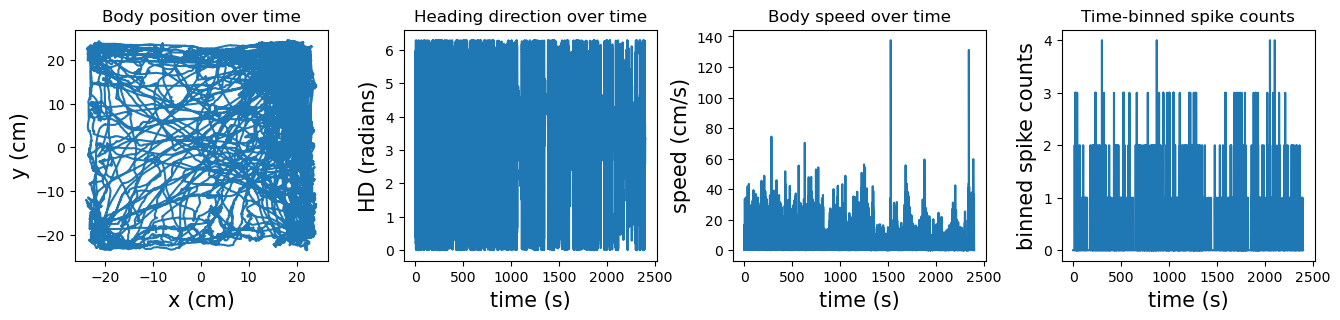

In [10]:
# Plot data

fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

ax[0].plot(data['body_position_x'], data['body_position_y'])
ax[0].set_xlabel('x (cm)', fontsize=15); ax[0].set_ylabel('y (cm)', fontsize=15)
ax[0].set_title('Body position over time')

ax[1].plot(time, data['azimuthal_head_direction'])
ax[1].set_xlabel('time (s)', fontsize=15); ax[1].set_ylabel('HD (radians)', fontsize=15)
ax[1].set_title('Heading direction over time')

ax[2].plot(time, data['body_speed'])
ax[2].set_xlabel('time (s)', fontsize=15); ax[2].set_ylabel('speed (cm/s)', fontsize=15)
ax[2].set_title('Body speed over time')

ax[3].plot(time, data['counts'][0])        # only visualize first neuron
ax[3].set_xlabel('time (s)', fontsize=15); ax[3].set_ylabel('binned spike counts', fontsize=15)
ax[3].set_title('Time-binned spike counts')


plt.subplots_adjust(wspace=0.3)
plt.show()

## 1. Split data into train/test sets

In order to assess goodness-of-fit later, we need to split our data set into two parts: a training set (which we use to fit model parameters), and a testing set (which we use to assess goodness-of-fit).

We will do an **80-20 train-test split**. A careful split would probably subsample the session; here, we will split by using the first 80% of session time points for training, and the last 20% of session time points for testing.

As a sanity check, here is what 2D position over time looks like for the first 80% of the session, versus the last 20%:

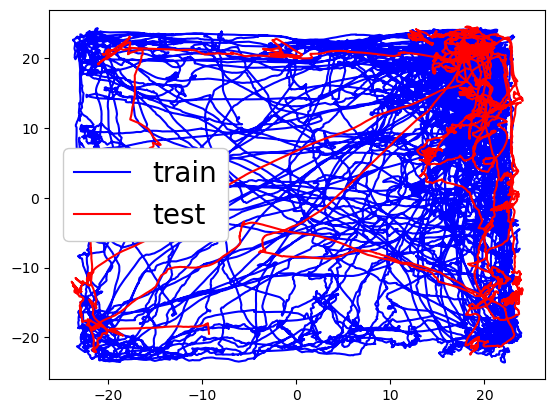

Statistically similar...OK!
Would be bad if, for example, the mouse was tired for last 20%, and just sat in one corner.


In [38]:
num_t_pts = len(x_t)
ind_cut = int(0.8*num_t_pts)
plt.plot(x_t[:ind_cut], y_t[:ind_cut], color='blue', label='train')
plt.plot(x_t[ind_cut:], y_t[ind_cut:], color='red', label='test')
plt.legend(fontsize=20,framealpha=1)
plt.show()

print('Statistically similar...OK!')
print('Would be bad if, for example, the mouse was tired for last 20%, and just sat in one corner.')

In [172]:
num_t_pts = len(x_t)
ind_cut = int(0.8*num_t_pts)

time_train, time_test = time[:ind_cut], time[ind_cut:]
x_train, x_test = x_t[:ind_cut], x_t[ind_cut:]
y_train, y_test = y_t[:ind_cut], y_t[ind_cut:]
HD_train, HD_test = HD_t[:ind_cut], HD_t[ind_cut:]             # FILL IN
speed_train, speed_test = speed_t[:ind_cut], speed_t[ind_cut:]

counts_train, counts_test = counts[:,:ind_cut], counts[:,ind_cut:]

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (96034,)
x_test shape: (24009,)


## Step 2. Construct state representation

Let's bin the behavioral data and construct the state representation we described above. 

First, we construct the bins. We will use $20 \times 20$ bins for 2D position, $18$ bins for heading direction, and $10$ bins for speed.

In [119]:
# Position bins
x_min, x_max = -25, 25
y_min, y_max = -25, 25
num_bins_x = 20
num_bins_y = 20
bins_x = np.linspace(x_min, x_max, num_bins_x + 1)
bins_y = np.linspace(y_min, y_max, num_bins_y + 1)

# Heading direction bins (range = 0 to 2 pi)
num_bins_HD = 18
bins_HD = np.linspace(0, 2*np.pi, num_bins_HD + 1)     # YOU FILL IN

# Speed bins
speed_max = np.amax(speed_t)
num_bins_speed = 10
bins_speed = np.linspace(0, speed_max, num_bins_speed + 1)

# bin centers, used only for plotting
dbin_HD = bins_HD[1] - bins_HD[0]
HD_centers = bins_HD[:-1] + dbin_HD/2
dbin_speed = bins_speed[1] - bins_speed[0]
speed_centers = bins_speed[:-1] + dbin_speed/2

Now we bin the behavioral data. We can do this with `np.digitize` ([documentation link](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html)).

In [43]:
def bin_behavior(x_t, y_t, HD_t, speed_t):
    x_dig = np.digitize(x_t, bins=bins_x) -1; x_dig = np.clip(x_dig, 0, num_bins_x-1)
    y_dig = np.digitize(y_t, bins=bins_y) -1; y_dig = np.clip(y_dig, 0, num_bins_y-1)
    HD_dig = np.digitize(HD_t, bins=bins_HD) -1; HD_dig = np.clip(HD_dig, 0, num_bins_HD-1) # YOU FILL IN
    speed_dig = np.digitize(speed_t, bins=bins_speed) - 1; speed_dig = np.clip(speed_dig, 0, num_bins_speed-1)

    return x_dig, y_dig, HD_dig, speed_dig

xd_train, yd_train, HDd_train, vd_train = bin_behavior(x_train, y_train, HD_train, speed_train)
xd_test, yd_test, HDd_test, vd_test = bin_behavior(x_test, y_test, HD_test, speed_test)

print(xd_train.shape)
print('Same shape as before, but this array contains indices that indicate which bin the current value falls in.')
print('For memory reasons, this is better than explicitly storing a time points x num_bins matrix.')

(96034,)
Same shape as before, but this array contains indices that indicate which bin the current value falls in.
For memory reasons, this is better than explicitly storing a time points x num_bins matrix.


Plot example: binned head direction over time.

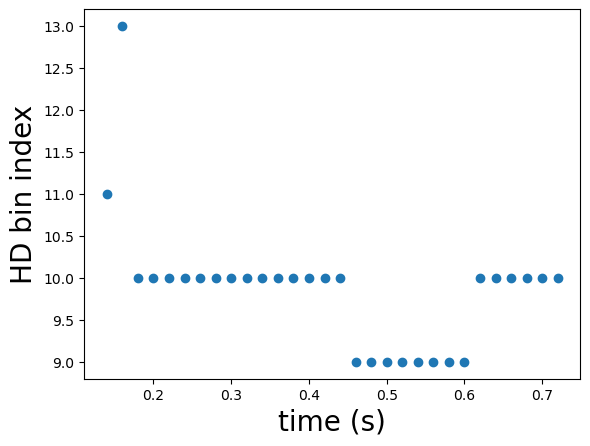

In [46]:
ind_max = 30
plt.scatter(time_train[:ind_max], HDd_train[:ind_max])
plt.xlabel('time (s)', fontsize=20)
plt.ylabel('HD bin index', fontsize=20)
plt.show()

## 3. Train Poisson GLM

We're now ready to train a Poisson GLM on the training set. First, let's write a function to initialize model parameters:

In [47]:
def init_model_params():
    w_bias = np.random.normal(size=1)
    w_P = np.random.normal(size=(num_bins_x, num_bins_y))
    w_H = np.random.normal(size=(num_bins_HD))
    w_S = np.random.normal(size=(num_bins_speed))
    return w_bias, w_P, w_H, w_S

Our objective function is
$$\begin{split}
J &= \log p + J_{reg} \\
\log p &= \sum_n y_n (\mathbf{w}^T \mathbf{x}_n + w_0) - e^{\mathbf{w}^T \mathbf{x} + w_0} \Delta t \\
J_{reg} &= -\ \beta_P \sum_{i, j} \left[ \frac{( w_{P, i+1, j} - w_{P i, j})^2 }{4} + \frac{( w_{P, i, j+1} - w_{P i, j})^2 }{4} \right] \ -  \beta_H \sum_i \frac{(w_{H, i+1} - w_{H i})^2}{2} 
- \ \beta_P \sum_i \frac{(w_{S, i+1} - w_{S i})^2}{2} 
\end{split}$$

and the corresponding gradients are

$$
\begin{split}
\frac{\partial J}{\partial w_0} &= \sum_n  y_n   - \hat{y}(\mathbf{x}_n; \mathbf{w}, w_0)  \\
\frac{\partial J}{\partial w_{P i j}} &= \sum_n \left[ y_n   - \hat{y}(\mathbf{x}_n; \mathbf{w}, w_0) \right] x_{P i j, n} +  \beta_P \left[  \frac{( w_{P, i+1, j} + w_{P, i-1, j} + w_{P, i, j+1} + w_{P, i, j-1}  ) }{4} - w_{P i, j} \right] \\
\frac{\partial J}{\partial w_{H i}} &= \sum_n \left[ y_n   - \hat{y}(\mathbf{x}_n; \mathbf{w}, w_0) \right] x_{H i, n}  +  \beta_H \left[  \frac{( w_{H, i+1} + w_{H, i-1} ) }{2} - w_{H i} \right] \\
\frac{\partial J}{\partial w_{S i}} &= \sum_n \left[ y_n   - \hat{y}(\mathbf{x}_n; \mathbf{w}, w_0) \right] x_{S i, n}  +  \beta_S \left[  \frac{( w_{S, i+1} + w_{S, i-1} ) }{2} - w_{S i} \right] \ .
\end{split}
$$

where $\hat{y}(\mathbf{x}_n; \mathbf{w}, w_0) := \exp( \mathbf{w}^T \mathbf{x}_n + w_0) \Delta t$ is the average model prediction. Note that the notation used here is a little sloppy; $x_{H i, n}$ for example refers to the value of $x_{H i}$ for the $n$-th sample / time point, which is either zero or one.

Let's write a function to compute the objective, so we can track training progress. Note that the objective is only a function of (i) counts, (ii) the predictor, and (iii) average model-predicted counts. We will denote those quantities below as $y$, $z$, and $\hat{y}$. (We also use $r$ and $\hat{r}$ below to avoid a collision of notation with the second position coordinate. Sorry about this!)

In [51]:
# to avoid very large values, this is actually a scaled objective; true obj would use np.sum, not np.mean
def get_minus_J(y, z, y_hat):
    minus_J = -np.mean(y*z) + np.mean(y_hat)
    return minus_J

Now let's write the training loop:

In [94]:
def train_model(r, data_raw, data_dig, params, hyper_params, num_grad_steps=100, lr=1e-4):
    """
    r: spike count data, shape = (num_t_pts)
    data_dig : tuple of binned behavior data
    params : trainable parameters
    hyper_params : 3 regularization parameters
    num_grad_steps : number of gradient descent iterations to perform
    lr : learning rate

    returns : modified params
    """

    x_t, y_t, HD_t, speed_t = data_raw
    x_dig, y_dig, HD_dig, speed_dig = data_dig
    
    w_bias, w_P, w_H, w_S = params['w_bias'], params['w_P'], params['w_H'], params['w_S']
    beta_P, beta_H, beta_S = hyper_params['beta_P'], hyper_params['beta_H'], hyper_params['beta_S']

    J = np.zeros(num_grad_steps)   # initialize J; use to track performance

    start = ti.perf_counter()       # start timing training
    for i in range(num_grad_steps):
        w_P_, w_H_, w_S_ = w_P[x_dig, y_dig], w_H[HD_dig], w_S[speed_dig]
        
        # forward pass
        z = w_P_ + w_H_ + w_S_ + w_bias
        r_hat = np.exp(z)*dt
    
        J[i] = get_minus_J(r, z, r_hat)   # use to track performance
    
        # ----------------

        dr = r - r_hat
    
        dw_P, _ = np.histogramdd( (x_t, y_t), bins=(bins_x, bins_y), weights=dr)  # uses trick to compute sum in way that saves memory
        dw_H, _ = np.histogram( HD_t, bins=bins_HD, weights=dr)
        dw_S, _ = np.histogram( speed_t, bins=bins_speed, weights=dr)
        dw_bias = np.sum(dr)
    
        w_P_shift11 = np.roll(w_P, 1, axis=0); w_P_shift11[0,:] = 0
        w_P_shift12 = np.roll(w_P, -1, axis=0); w_P_shift12[-1,:] = 0
        w_P_shift21 = np.roll(w_P, 1, axis=1); w_P_shift11[:,0] = 0
        w_P_shift22 = np.roll(w_P, -1, axis=1); w_P_shift12[:,-1] = 0
        w_P_reg = beta_P*( 0.25*(w_P_shift11 + w_P_shift12 + w_P_shift21 + w_P_shift22) - w_P)
        
        w_H_reg = beta_H*(0.5*(np.roll(w_H, 1) + np.roll(w_H,-1)) - w_H) 
        
        w_S_shift1 = np.roll(w_S, 1); w_S_shift1[0] = 0
        w_S_shift2 = np.roll(w_S, -1); w_S_shift2[-1] = 0
        w_S_reg = beta_S*(0.5*(w_S_shift1 + w_S_shift2) - w_S)
        
        w_P += lr*( dw_P + w_P_reg )
        w_H += lr*( dw_H + w_H_reg )
        w_S += lr*( dw_S + w_S_reg )
        w_bias += lr*dw_bias

        if i%100==0:
            print('finished iteration', i)

    end = ti.perf_counter(); print('Training time (s):', end-start)   # print elapsed training time
        
    params['w_bias'], params['w_P'], params['w_H'], params['w_S'] = w_bias, w_P, w_H, w_S
    return params, J

Now let's actually train a model and see what happens. We will train on one neuron at a time. 

In [163]:
beta_P, beta_H, beta_S = 100, 50, 10
hyper_params = {'beta_P':beta_P, 'beta_H':beta_H, 'beta_S':beta_S}

w_bias, w_P, w_H, w_S = init_model_params()  # initialize model
params = {'w_bias':w_bias, 'w_P':w_P, 'w_H':w_H, 'w_S':w_S}

data_raw = x_train, y_train, HD_train, speed_train
data_dig = xd_train, yd_train, HDd_train, vd_train

In [164]:
lr = 1e-4
num_grad_steps = 500

r = counts_train[0]   # train on first neuron
params, J = train_model(r, data_raw, data_dig, params, hyper_params, num_grad_steps=num_grad_steps, lr=lr)

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
Training time (s): 22.5831756000116


Let's check the results to see if they make sense:

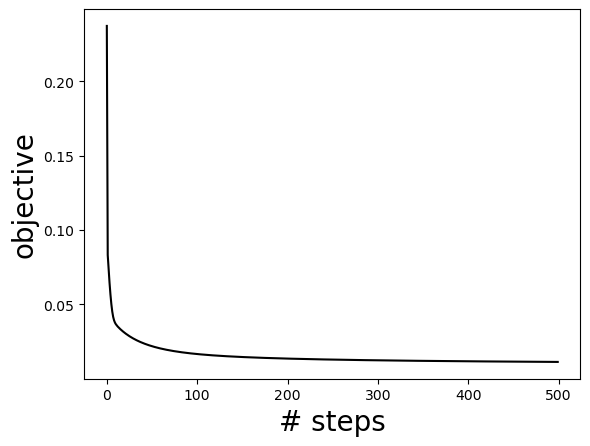

In [165]:
plt.plot(J, color='black')
plt.xlabel('# steps', fontsize=20)
plt.ylabel('objective', fontsize=20)
plt.show()

In [166]:
w_bias_, w_P_, w_H_, w_S_ = params['w_bias'], params['w_P'], params['w_H'], params['w_S']

tune_P = np.exp(w_P_ + w_bias_)
tune_HD = np.exp(w_H_ + w_bias_)
tune_S = np.exp(w_S_ + w_bias_)

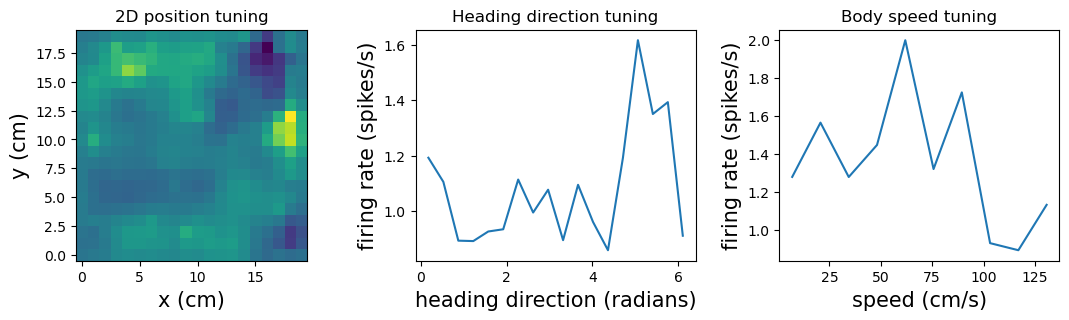

In [167]:
fig, ax = plt.subplots(ncols=3, figsize=(13, 3))

ax[0].imshow(np.transpose(w_P), origin='lower')
ax[0].set_xlabel('x (cm)', fontsize=15); ax[0].set_ylabel('y (cm)', fontsize=15)
ax[0].set_title('2D position tuning')

ax[1].plot(HD_centers, tune_HD)
ax[1].set_xlabel('heading direction (radians)', fontsize=15); ax[1].set_ylabel('firing rate (spikes/s)', fontsize=15)
ax[1].set_title('Heading direction tuning')

ax[2].plot(speed_centers, tune_S)
ax[2].set_xlabel('speed (cm/s)', fontsize=15); ax[2].set_ylabel('firing rate (spikes/s)', fontsize=15)
ax[2].set_title('Body speed tuning')

plt.subplots_adjust(wspace=0.3)
plt.savefig('results/tuning_curves.pdf', bbox_inches='tight')
plt.show()

Play with the training hyperparameters (the regularization coefficients, the learning rate, the number of gradient descent steps) and see how the results change! 

If you get weird results, try decreasing the learning rate and increasing the number of steps.

Note that a careful treatment of this problem would choose these hyperparameters by considering a range of possible values, and comparing each of them using a strategy like cross-validation.

## 4. Assess goodness-of-fit

We can assess the goodness-of-fit of our model using **fraction deviance explained**, which is analogous to the more familiar **fraction variance explained**. Since squared error is not an appropriate measure of how good a Poisson model fits, we need to use a different quantity: the Poisson [deviance](https://en.wikipedia.org/wiki/Deviance_(statistics)). 

The idea is to compare the log-likelihood of a given model fit to two extremes. One extreme is the **saturated model**, which involves a separate parameter for each data point, and hence fits the data perfectly. The other extreme is a **null model**, which only fits the mean of the data (equivalently: only the $w_0$ term is retained, and all other weights are removed). 

Define the **fraction deviance explained** as
$$
R^2_{GLM} := \frac{D_{model}}{D_{tot}} \geq 0 \ ,
$$
where the explained deviance $D_{model}$ is defined via
\begin{equation}
\begin{split}
D_{model} &= 2 \sum_n \left[ \ y_n \left( \mathbf{w}^T \mathbf{x}_n + w_0 - \log\langle y \rangle \right) - (e^{\mathbf{w}^T \mathbf{x}_n + w_0} - \langle y \rangle) \ \right]
\end{split}
\end{equation}
where $\langle y \rangle := \sum_n y_n/N$, and the total deviance $D_{tot}$ is defined via
\begin{equation}
D_{tot} := 2 \sum_n \left[ \ y_n \log(y_n/\langle y \rangle) - (y_n - \langle y \rangle) \ \right] \ .
\end{equation}
See the notes for more math details and discussion.

Let's write a function to compute the fraction deviance explained:

In [170]:
def get_frac_dev_explained(r, data_dig, params):
    x_dig, y_dig, HD_dig, speed_dig = data_dig
    w_bias, w_P, w_H, w_S = params['w_bias'], params['w_P'], params['w_H'], params['w_S']

    
    r_avg = np.mean(r)   # compute output sample mean

    # forward pass
    w_P_, w_H_, w_S_ = w_P[x_dig, y_dig], w_H[HD_dig], w_S[speed_dig]
    z = w_P_ + w_H_ + w_S_ + w_bias
    r_hat = np.exp(z)*dt

    eps = 1e-12    # to avoid numerical instability when computing 0 log 0; can also use the xlogy scipy.special function
    D_model = 2*np.sum( r*(z - np.log(r_avg)) - (r_hat - r_avg)  )
    D_tot = 2*np.sum( r*np.log((r + eps)/r_avg) - (r - r_avg) )

    frac = D_model/D_tot
    return frac

In [173]:
data_dig_test = xd_test, yd_test, HDd_test, vd_test

r_test = counts_test[0] 
frac_test = get_frac_dev_explained(r_test, data_dig_test, params)
print('Test set fraction deviance explained:', frac_test)

frac_train = get_frac_dev_explained(r, data_dig, params)
print('Training set fraction deviance explained:', frac_train)

print('Note: values may be greater than 1! Higher = better!')

Test set fraction deviance explained: 0.8813601349736983
Training set fraction deviance explained: 1.070240396464342
Note: values may be greater than 1! Higher = better!
